In [1]:
# !Convert*first_ADMM_primal.py*w*sh*

In [2]:
import math

import numpy

In [3]:
def init(m, n):
    s = numpy.zeros((m, n))
    s_ = numpy.zeros((m, n))

    e = numpy.zeros((m, n))
    
    lamda = numpy.zeros(m)
    eta = numpy.zeros(n)
    
    return s, s_, e, lamda, eta

In [4]:
def update(m, n, mu, nu, ubox, c, s, s_, e, lamda, eta, rho, alpha):
    k = (
          (
              e
            + lamda.reshape((m, 1))
            + eta.reshape((1, n))
            - c
          ) / rho
        + mu.reshape((m, 1))
        + nu.reshape((1, n))
        + s_
    )
    
    s = (
          k
        - ((k.sum(axis=1) - k.sum() / (m + n + 1)) / (n + 1)).reshape((m, 1))
        - ((k.sum(axis=0) - k.sum() / (m + n + 1)) / (m + 1)).reshape((1, n))
    )
    
    s_ = s - e / rho
    s_ = numpy.maximum(s_, 0.)
    if ubox is not None:
        s_ = numpy.minimum(s_, ubox)
    
    lamda = lamda + alpha * rho * (mu - s.sum(axis=1))
    
    eta = eta + alpha * rho * (nu - s.sum(axis=0))
    
    e = e + alpha * rho * (s_ - s)
    
    return s, s_, e, lamda, eta

In [5]:
def solve_ADMM_primal(
    p,
    scale=None, its=[], rhos=[], alphas=[], epss=None, min_its=None,
    fh=None, figs={}, log=None, stat=False,
    *args, **kwargs
):
    m, n = p.c.shape
    
    if scale is None:
        scale = math.sqrt(m * n)
    
    mu, nu = scale*p.mu, scale*p.nu
    c = p.c
    ubox = p.ubox
    if ubox is not None:
        ubox *= scale
    
    if fh is not None:
        if "error" in figs:
            error_mu = []
            error_nu = []
            error_s = []
        if "loss" in figs:
            loss = []
    
    s, s_, e, lamda, eta = init(m, n)
    
    l = len(its)
    itc = 0
    
    for i in range(l):
        for j in range(its[i]):
            s, s_, e, lamda, eta = update(m, n, mu, nu, ubox, c, s, s_, e, lamda, eta, rhos[i], alphas[i])

            itc += 1

            if fh is not None:
                if "error" in figs:
                    error_mu.append(numpy.linalg.norm(s_.sum(axis=1) - mu, 1) / scale)
                    error_nu.append(numpy.linalg.norm(s_.sum(axis=0) - nu, 1) / scale)
                    error_s.append(numpy.linalg.norm(s_ - s))
                if "loss" in figs:
                    loss.append((c * s).sum() / scale)

            if epss is not None:
                if (
                        numpy.linalg.norm(s_.sum(axis=1) - mu, 1) / scale < epss[i]
                    and numpy.linalg.norm(s_.sum(axis=0) - nu, 1) / scale < epss[i]
                ):
                    if min_its is None or j > min_its[i]:
                        break
                    
            if log is not None:
                log("i, j, itc = {0}, {1}, {2}".format(i, j, itc))
    
    p.s = s_ / scale
    
    if fh is not None:
        if "error" in figs:
            fh.new(1, 1, 1)
            fh.ax.semilogy(numpy.array(error_mu), label="Error of mu")
            fh.ax.semilogy(numpy.array(error_nu), label="Error of nu")
            fh.ax.semilogy(numpy.array(error_s), label="Error of s")
            fh.ax.legend()
            fh.show()
            fh.close()
        if "loss" in figs:
            fh.new(1, 1, 1)
            fh.ax.plot(numpy.array(loss), label="Loss")
            fh.ax.legend()
            fh.show()
            fh.close()
    
    if stat:
        s = {
            "title": "ADMM on primal",
            "size": [m, n],
            "loss": (c * s_).sum() / scale,
            "vars": 3*m*n + m + n,
            "iters": itc,
        }
        return p, s
    else:
        
        
        return p

In [6]:
# !ConvertEnd*

In [7]:
# !Convert*first_ADMM_primal_test.py*w*sehx*

In [8]:
import numpy

# !Switch*
from handler import FigureHandler
from dataset import ot_2d_Caffarelli
from stats import Statistics
# !SwitchCase*
# import font
# from handler import FigureHandler
# from dataset import ot_2d_Caffarelli
# from stats import Statistics
# from first_ADMM_primal import solve_ADMM_primal
# !SwitchEnd*

In [9]:
# !Switch*
fh = FigureHandler(redir=True)
# !SwitchCase*
# fh = FigureHandler(sav=True, disp=False, ext=".pgf", redir=True)
# !SwitchEnd*

Log-01-20180107-135843-174525.log created


In [10]:
stat = Statistics(
    probs=[
        ot_2d_Caffarelli(100, 100, 1)
    ],
    prob="Test problems",
    log=fh.write,
)

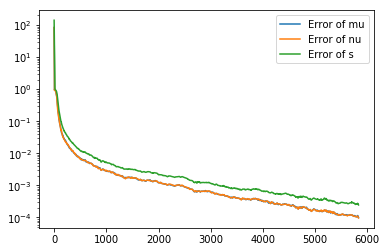

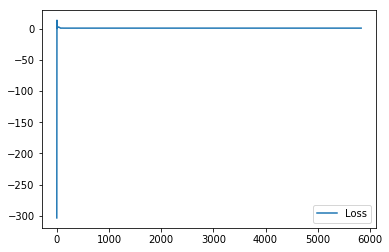

Problem: Test problems
Title: ADMM on primal
Function name: solve_ADMM_primal
Time: 28.22408+-0.00000~[28.22408390045166]
Variables: [478401]
Average iterations: [5833]
Loss: 9.9505472e-01+-0.0000000e+00
Check loss: 9.9505472e-01+-0.0000000e+00~[0.99505472151411234]
Negative part of solution: 0.0000000e+00+-0.0000000e+00~[0.0]
Normalized error of mu: 9.9371966e-05+-0.0000000e+00~[9.9371966403246498e-05]
Normalized error of nu: 9.6883747e-05+-0.0000000e+00~[9.6883747228720171e-05]


In [11]:
stat.test(
    solve_ADMM_primal,
    its=[10000],
    rhos=[3.],
    alphas=[1.618],
    epss=[1e-4],
    fh=fh, figs={"error", "loss"},
)
stat.output_last()

In [12]:
stat.test(
    solve_ADMM_primal,
    its=[10000],
    rhos=[3.],
    alphas=[1.618],
    epss=[1e-4],
)
stat.output_last()

Problem: Test problems
Title: ADMM on primal
Function name: solve_ADMM_primal
Time: 22.29100+-0.00000~[22.29100275039673]
Variables: [478401]
Average iterations: [5833]
Loss: 9.9505472e-01+-0.0000000e+00
Check loss: 9.9505472e-01+-0.0000000e+00~[0.99505472151411234]
Negative part of solution: 0.0000000e+00+-0.0000000e+00~[0.0]
Normalized error of mu: 9.9371966e-05+-0.0000000e+00~[9.9371966403246498e-05]
Normalized error of nu: 9.6883747e-05+-0.0000000e+00~[9.6883747228720171e-05]


In [13]:
from solver_mosek import solve_mosek_interior_point

In [14]:
stat.test(
    solve_mosek_interior_point,
)
stat.output_last()

Problem: Test problems
Title: MOSEK, interior point
Function name: solve_mosek_interior_point
Problem size: [[399, 399]]
Time: 1.06400+-0.00000~[1.0639972686767578]
Setup time: 0.10655+-0.00000
Solve time: 0.92850+-0.00000
Variables: [159201]
Average iterations: [13]
Loss: 9.9502057e-01+-0.0000000e+00
Check loss: 9.9502057e-01+-0.0000000e+00~[0.99502057113652975]
Negative part of solution: 0.0000000e+00+-0.0000000e+00~[0.0]
Normalized error of mu: 8.7364794e-13+-0.0000000e+00~[8.736479421844745e-13]
Normalized error of nu: 8.7710872e-13+-0.0000000e+00~[8.7710871551904823e-13]


In [15]:
prob = stat.probs[0]
m, n = prob.c.shape
prob.ubox = numpy.minimum(prob.mu.reshape((m, 1)), prob.nu.reshape((1, n)))

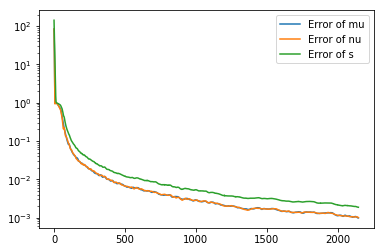

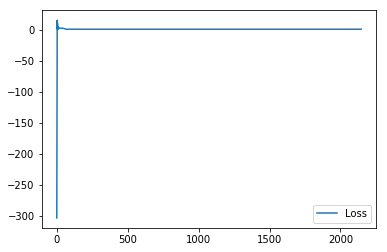

Problem: Test problems
Title: ADMM on primal
Function name: solve_ADMM_primal
Time: 10.89610+-0.00000~[10.896101236343384]
Variables: [478401]
Average iterations: [2147]
Loss: 9.9518324e-01+-0.0000000e+00
Check loss: 9.9518324e-01+-0.0000000e+00~[0.99518324452005125]
Negative part of solution: 0.0000000e+00+-0.0000000e+00~[0.0]
Normalized error of mu: 9.8058597e-04+-0.0000000e+00~[0.00098058597184295286]
Normalized error of nu: 9.9742872e-04+-0.0000000e+00~[0.00099742871542103217]


In [16]:
stat.test(
    solve_ADMM_primal,
    its=[10000],
    rhos=[3.],
    alphas=[1.618],
    epss=[1e-3],
    fh=fh, figs={"error", "loss"},
)
stat.output_last()

In [17]:
prob.ubox = numpy.minimum(prob.mu.reshape((m, 1)), prob.nu.reshape((1, n))) / 2.

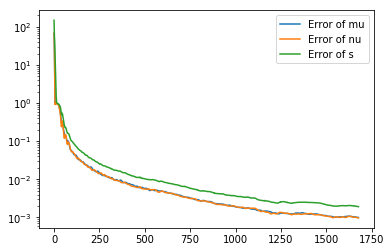

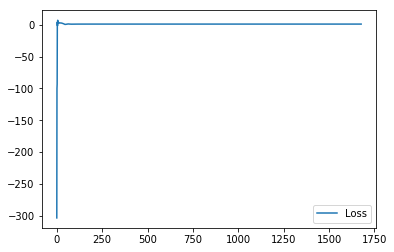

Problem: Test problems
Title: ADMM on primal
Function name: solve_ADMM_primal
Time: 8.64009+-0.00000~[8.640085935592651]
Variables: [478401]
Average iterations: [1678]
Loss: 9.9597867e-01+-0.0000000e+00
Check loss: 9.9597867e-01+-0.0000000e+00~[0.99597867248498906]
Negative part of solution: 0.0000000e+00+-0.0000000e+00~[0.0]
Normalized error of mu: 9.9941022e-04+-0.0000000e+00~[0.00099941021751968071]
Normalized error of nu: 9.7247141e-04+-0.0000000e+00~[0.00097247141260124953]


In [18]:
stat.test(
    solve_ADMM_primal,
    its=[10000],
    rhos=[3.],
    alphas=[1.618],
    epss=[1e-3],
    fh=fh, figs={"error", "loss"},
    clean=False
)
stat.output_last()

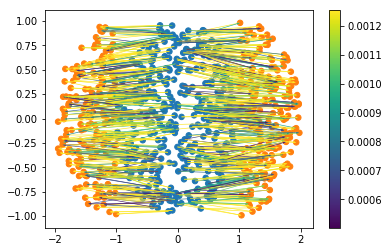

In [19]:
fh.fast(prob.plot_link)

In [20]:
fh.write(str((prob.s < 0.).sum()))
fh.write(str((prob.s > prob.ubox).sum()))

0
0


In [21]:
# !ConvertEnd*